In [1]:
library(tidyr)
library(dplyr)
library(corrplot)


lifeData <- read.csv("C:/Code/BIOSTAT682/Life Expectancy_v4.csv")

dim(lifeData)
head(lifeData)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'corrplot' was built under R version 4.2.2"
corrplot 0.92 loaded



[1] 1646   18

,Country,Year,Status,Life.expectancy,Adult.Mortality,Alcohol,Hepatitis.B,Measles,BMI,Polio,Total.expenditure,Diphtheria,HIV.AIDS,GDP,Population,thinness.1.19.years.,Income.composition.of.resources,Schooling
,<chr>,<int>,<chr>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Afghanistan,2015,Developing,65.0,263,0.01,65,1154,19.1,6,8.16,65,0.1,0.005842592,33736494,17.2,0.479,10.1
2,Afghanistan,2014,Developing,59.9,271,0.01,62,492,18.6,58,8.18,62,0.1,0.006126965,32758200,17.5,0.476,10.0
3,Afghanistan,2013,Developing,59.9,268,0.01,64,430,18.1,62,8.13,64,0.1,0.006317450,31731688,17.7,0.470,9.9
4,Afghanistan,2012,Developing,59.5,272,0.01,67,2787,17.6,67,8.52,67,0.1,0.006699590,36969580,17.9,0.463,9.8
5,Afghanistan,2011,Developing,59.2,275,0.01,68,3013,17.2,68,7.87,68,0.1,0.006353723,29785990,18.2,0.454,9.5
6,Afghanistan,2010,Developing,58.8,279,0.01,66,1989,16.7,66,9.20,66,0.1,0.005533289,28831670,18.4,0.448,9.2


In [2]:
lifeData_train <- lifeData %>% filter(Year < 2013)
lifeData_test <- lifeData %>% filter(Year >= 2013)
dim(lifeData_train)
dim(lifeData_test)

[1] 1386   18

[1] 260  18

In [3]:
library(R2jags)

status = rep(0,nrow(lifeData_train))

for (i in 1:nrow(lifeData_train)) {
  status[i] = ifelse(lifeData_train$Status[i]=="Developing",0,1)
}
mortality = lifeData_train$"Adult.Mortality"
alcohol = lifeData_train$"Alcohol"
hepB = lifeData_train$"Hepatitis.B"
measles = lifeData_train$"Measles"
BMI = lifeData_train$"BMI"
polio = lifeData_train$"Polio"
totalExp = lifeData_train$"Total.expenditure"
dipth = lifeData_train$"Diphtheria"
hivaids = lifeData_train$"HIV.AIDS"
gdp = lifeData_train$"GDP"
pop = lifeData_train$"Population"
thin1019 = lifeData_train$"thinness.1.19.years"
incomeComp = lifeData_train$"Income.composition.of.resources"
school = lifeData_train$"Schooling"
y = lifeData_train$"Life.expectancy"
N = length(lifeData_train$Country) #go through each point
J = length(unique(lifeData_train$Country)) #go through each country

# encode country
indicesDict = c(unique(lifeData_train$Country))
indices = rep(0,N)
for (i in 1:N) {
  indices[i] = which(indicesDict==lifeData_train$Country[i])
}

Loading required package: rjags

Loading required package: coda

Linked to JAGS 4.3.1

Loaded modules: basemod,bugs


Attaching package: 'R2jags'


The following object is masked from 'package:coda':

    traceplot




In [4]:
save.parms.0 = c("beta")
life_expectancy.data.0 = c("y","mortality","alcohol", "status",
                            "hepB","measles","BMI","polio","totalExp",
                            "dipth","hivaids","gdp","pop","thin1019",
                            "incomeComp","school","N")    

life_expectancy.model.0 = function()
{
  for (i in 1:N) {
     y[i] ~ dnorm(mu[i],tau) #could do tau*k bc precision
     #indices[i] gets the cluster number
     mu[i] <- 
          beta[1] # intercept
          + beta[2]*status[i]
          + beta[3]*mortality[i] 
          + beta[4]*alcohol[i] 
          + beta[5]*hepB[i] 
          + beta[6]*measles[i] 
          + beta[7]*BMI[i] 
          + beta[8]*polio[i] 
          + beta[9]*totalExp[i] 
          + beta[10]*dipth[i] 
          + beta[11]*hivaids[i] 
          + beta[12]*gdp[i] 
          + beta[13]*pop[i] 
          + beta[14]*thin1019[i] 
          + beta[15]*incomeComp[i] 
          + beta[16]*school[i] 
  }
  for (k in 1:16) {
    beta[k] ~ dnorm(0,1e-6)
  }
  tau ~ dgamma(1e-6,1e-6)
}

In [5]:
life_expectancy.out.0 = jags(data=life_expectancy.data.0,parameters.to.save=save.parms.0,model.file=life_expectancy.model.0,
                           n.chains=3,n.iter=10000,n.burnin=2000,n.thin=1)
print(life_expectancy.out.0, digits = 6)

module glm loaded



Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1386
   Unobserved stochastic nodes: 17
   Total graph size: 30440

Initializing model

Inference for Bugs model at "C:/Users/MINGCH~1/AppData/Local/Temp/RtmpQRXQI6/modelee8126c1851.txt", fit using jags,
 3 chains, each with 10000 iterations (first 2000 discarded)
 n.sims = 24000 iterations saved
             mu.vect  sd.vect        2.5%         25%         50%         75%
beta[1]    63.013208 0.886193   61.278277   62.417895   63.014678   63.614327
beta[2]     0.228100 0.287777   -0.339631    0.034656    0.227154    0.424208
beta[3]    -0.044317 0.001215   -0.046698   -0.045126   -0.044321   -0.043499
beta[4]    -0.028594 0.028755   -0.084770   -0.047847   -0.028608   -0.009185
beta[5]    -0.004141 0.005226   -0.014485   -0.007666   -0.004107   -0.000608
beta[6]     0.000001 0.000007   -0.000013   -0.000003    0.000002    0.000006
beta[7]     0.050171 0.008106  

In [6]:
attach.jags(life_expectancy.out.0)
beta.0 <- mcmc(beta)
beta.0 <- apply(beta.0, 2, mean)

In [8]:
X.0 = cbind(rep(1, N), status, mortality, alcohol, hepB, measles, BMI,
          polio, totalExp, dipth, hivaids, gdp, pop, thin1019, incomeComp, school)
fit.0 = X.0 %*% beta.0
residual.0 <- as.vector(fit.0 - lifeData_train[,4])

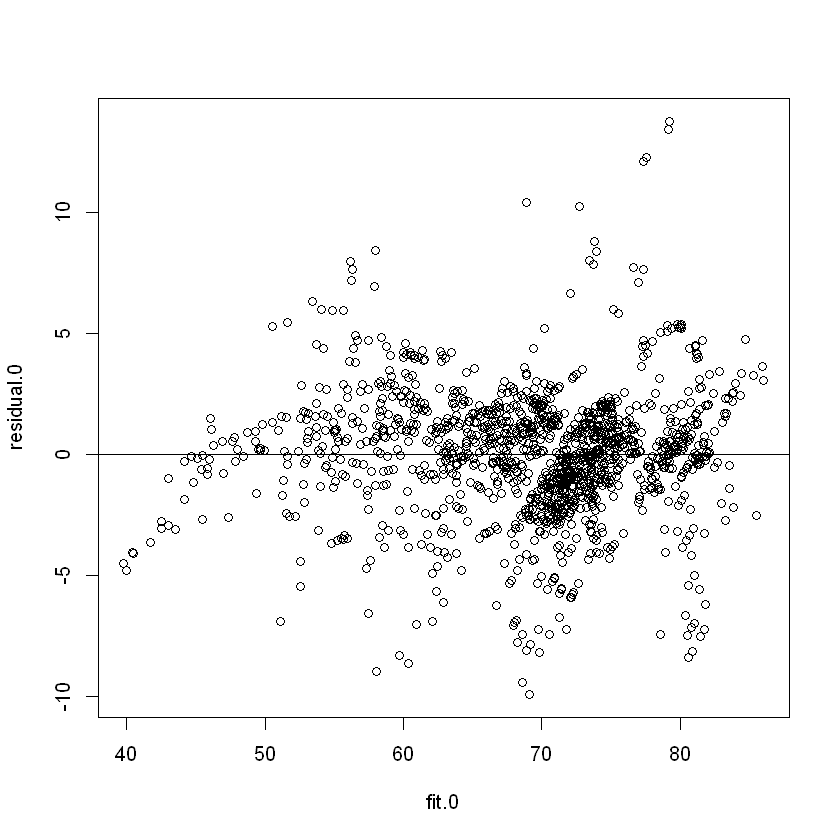

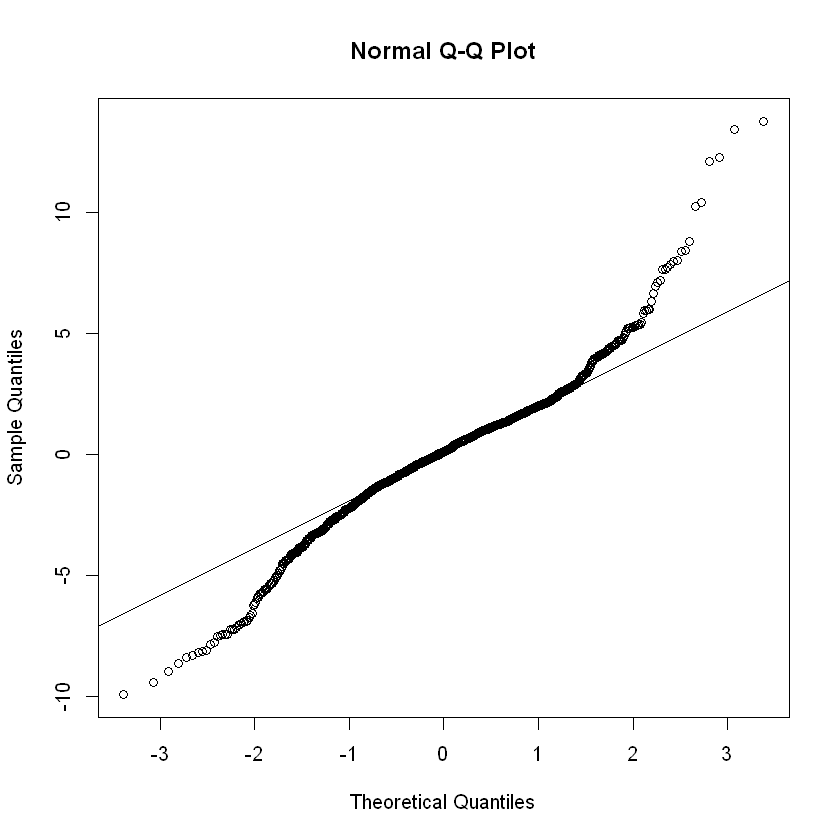

In [9]:
plot(fit.0, residual.0)
abline(h = 0)

qqnorm(residual.0)
qqline(residual.0)

# Test

In [17]:
rmse <- function(x,y) {
    return(sqrt(mean((x-y)^2)))
}

In [12]:
status_test = rep(0,nrow(lifeData_test))
for (i in 1:nrow(lifeData_test)) {
  status_test[i] = ifelse(lifeData_test$Status[i]=="Developing",0,1)
}
mortality_test = lifeData_test$"Adult.Mortality"
alcohol_test = lifeData_test$"Alcohol"
hepB_test = lifeData_test$"Hepatitis.B"
measles_test = lifeData_test$"Measles"
BMI_test = lifeData_test$"BMI"
polio_test = lifeData_test$"Polio"
totalExp_test = lifeData_test$"Total.expenditure"
dipth_test = lifeData_test$"Diphtheria"
hivaids_test = lifeData_test$"HIV.AIDS"
gdp_test = lifeData_test$"GDP"
pop_test = lifeData_test$"Population"
thin1019_test = lifeData_test$"thinness.1.19.years"
incomeComp_test = lifeData_test$"Income.composition.of.resources"
school_test = lifeData_test$"Schooling"

In [15]:
X.0_test = cbind(rep(1, nrow(lifeData_test)), status_test, mortality_test, alcohol_test, hepB_test, measles_test, BMI_test,
          polio_test, totalExp_test, dipth_test, hivaids_test, gdp_test, pop_test, thin1019_test, incomeComp_test, school_test)
fit.0_test = X.0_test %*% beta.0

In [18]:
rmse(fit.0_test, lifeData_test[,4])

[1] 3.34212